## DL4US Final Project - KADOWAKI Shuhei
### prj 1. Create a Street-Classifier
The classifier predicts *where each input street photograph is taken*,   with trasfer-learning or fine-tuning of VGG16 trained on [Places365 dataset designed by MIT](http://places2.csail.mit.edu/).  
e.g.) "This street is in Kyoto!"  

### prj 2. Interpret the learning results
Furthermore, if the fine-tuned network achieves good results, I want to interpret *how those results come*, using **[Grad-CAM](https://qiita.com/icoxfog417/items/8689f943fd1225e24358)** method.  
e.g.) "This street is in Kyoto, *because of its absolutely cool atmosphere and beautiful people and and ...*"

### Preparation

#### authorize the access to my Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/G')
!ls G/'My Drive'/prj

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/G
aviatesk.docx  demo_result.png	models		    refs     ~WRL1175.tmp
aviatesk.pdf   figs		notebook.ipynb	    results
data	       hists		notebook_sub.ipynb  run.py
demo.png       ~$iatesk.docx	__pycache__	    src


In [0]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from PIL import Image
from tqdm import tqdm

dir_path = os.path.join('G', 'My Drive', 'prj')
gc_path = os.path.join('.')
print('dir_path:', dir_path)
print('gc_path:', gc_path)
sys.path.append(os.path.join(dir_path, 'src'))

dir_path: G/My Drive/prj
gc_path: .


In [0]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

#### set target cities

In [4]:
cities = ('london', 'moscow', 'nyc', 'paris', 'vancouver', 'beijing', 'kyoto',
          'seoul', 'singapore', 'tokyo')

#### unzip data

In [0]:
!unzip G/'My Drive'/prj/data/processed/processed_data.zip
!ls

Archive:  G/My Drive/prj/data/processed/processed_data.zip
  inflating: beijing.npy             
  inflating: kyoto.npy               
  inflating: london.npy              
  inflating: moscow.npy              
  inflating: nyc.npy                 
  inflating: paris.npy               
  inflating: seoul.npy               
  inflating: singapore.npy           
  inflating: tokyo.npy               
  inflating: vancouver.npy           
beijing.npy  kyoto.npy	 moscow.npy  paris.npy	  seoul.npy	 tokyo.npy
G	     london.npy  nyc.npy     sample_data  singapore.npy  vancouver.npy


#### check unzipped data

london: (482, 224, 224, 3)


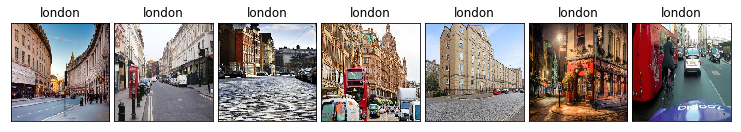

moscow: (379, 224, 224, 3)


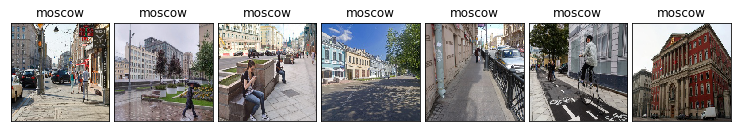

nyc: (503, 224, 224, 3)


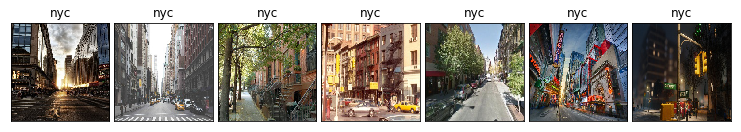

paris: (436, 224, 224, 3)


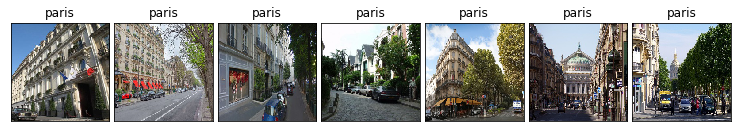

vancouver: (354, 224, 224, 3)


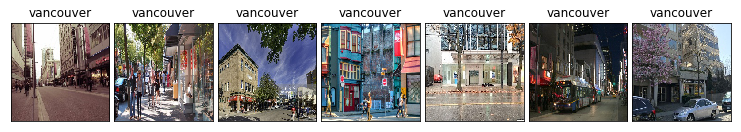

beijing: (434, 224, 224, 3)


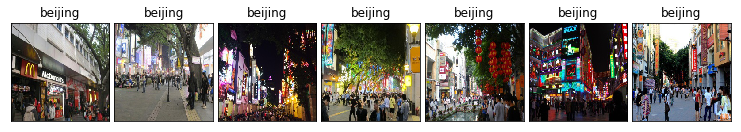

kyoto: (553, 224, 224, 3)


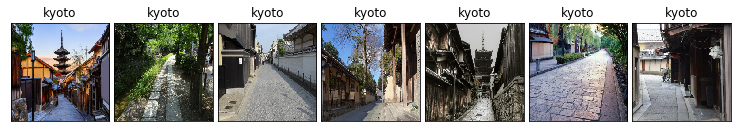

seoul: (353, 224, 224, 3)


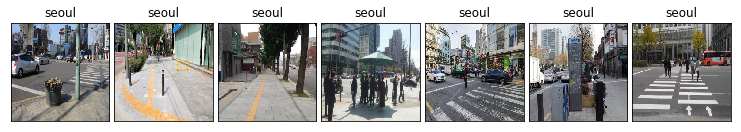

singapore: (275, 224, 224, 3)


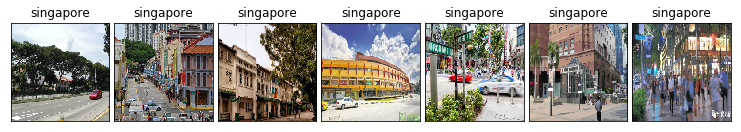

tokyo: (382, 224, 224, 3)


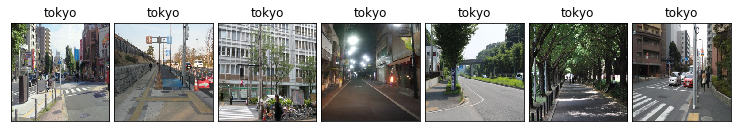

In [9]:
from utils import show_data

for city_name in cities:
    city_data = np.load(os.path.join(gc_path, city_name + '.npy'))
    show_data(city_name, city_data, num_show=7)
    plt.show()

del city_data

### SVM on the Extracted Deep Features

In [0]:
import time
from extract import extract_gc
from load_data import set_extracted_data
from sklearn.svm import SVC
from utils import report

dir_name = 'svm-on-extracted-features'

#### without augmentation

##### extract and set the extracted data


In [0]:
s0 = time.time()

augment_mode, augment_times = 0, 1

extracted_data = extract_gc(
    cities,
    gc_path=gc_path,
    weights='places',
    pooling='avg',
    test_size=0.2,
    random_state=42,
    augment=False,
    augment_mode=augment_mode,
    augment_times=augment_times,
    verbose=0,
)

(X_pld_train, X_pld_test), (X_npld_train, X_npld_test), (y1_train, y1_test), (
    y2_train, y2_test), (label2class1, label2class2) = set_extracted_data(
        extracted_data, cities=cities, verbose=1)

e0 = time.time()
print('{:.2f} min used for extraction:'.format((e0 - s0) / 60))

- test_size: 0.2 - augment: False - augment_mode: 0 augment_times: 1
extracting london data ...
extracting moscow data ...
extracting nyc data ...
extracting paris data ...
extracting vancouver data ...
extracting beijing data ...
extracting kyoto data ...
extracting seoul data ...
extracting singapore data ...
extracting tokyo data ...
returned: (X_pld_train, X_pld_test), (X_npld_train, X_npld_test), (y1_train, y1_test), (y2_train, y2_test), (label2class1, label2class2)
X_pld_train: (3317, 512)
X_pld_test: (834, 512)
X_npld_train: (3317, 25088)
X_npld_test: (834, 25088)
y1_train: (3317,)
y1_test: (834,)
y2_train: (3317,)
y2_test: (834,)
label2class1: [(0, 'Western'), (1, 'Eastern')]
label2class2: [(0, 'london'), (1, 'moscow'), (2, 'nyc'), (3, 'paris'), (4, 'vancouver'), (5, 'beijing'), (6, 'kyoto'), (7, 'seoul'), (8, 'singapore'), (9, 'tokyo')]
2.37 min used for extraction:


##### classify and report


###### pooled data

----- train -----
accuracy: 0.9599 %
             precision    recall  f1-score   support

    Western     0.9563    0.9669    0.9616      1721
    Eastern     0.9639    0.9524    0.9581      1596

avg / total     0.9599    0.9599    0.9599      3317

----- test -----
accuracy: 0.8118 %
             precision    recall  f1-score   support

    Western     0.8194    0.8176    0.8185       433
    Eastern     0.8035    0.8055    0.8045       401

avg / total     0.8118    0.8118    0.8118       834

figure saved successfully to G/My Drive/dl4us/prj/figs/svm-on-extracted-features/category1-pooled-noaugmentation.png


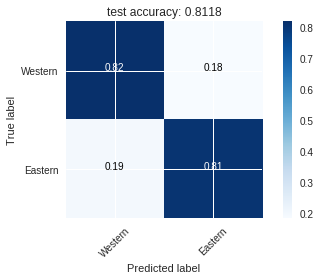

0.22 min used for category1-pooled-noaugmentation:

----- train -----
accuracy: 0.9074 %
             precision    recall  f1-score   support

     london     0.8710    0.9117    0.8909       385
     moscow     0.9283    0.8977    0.9128       303
        nyc     0.8720    0.9154    0.8932       402
      paris     0.9144    0.9511    0.9324       348
  vancouver     0.8982    0.8728    0.8853       283
    beijing     0.9240    0.9107    0.9173       347
      kyoto     0.9205    0.9434    0.9318       442
      seoul     0.9325    0.8333    0.8801       282
  singapore     0.9717    0.9364    0.9537       220
      tokyo     0.8812    0.8754    0.8783       305

avg / total     0.9082    0.9074    0.9074      3317

----- test -----
accuracy: 0.5288 %
             precision    recall  f1-score   support

     london     0.4444    0.5361    0.4860        97
     moscow     0.5373    0.4737    0.5035        76
        nyc     0.5088    0.5743    0.5395       101
      paris     0.5729 

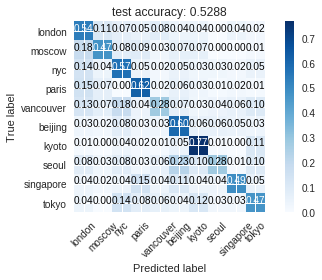

0.34 min used for category2-pooled-noaugmentation:

0.56 min used for pooled-noaugmentation:


In [0]:
base_name = 'pooled-noaugmentation'

s1 = time.time()

model = SVC(kernel='rbf', C=1.0)
model.fit(X_pld_train, y1_train)
y1_train_pred = model.predict(X_pld_train)
y1_test_pred = model.predict(X_pld_test)

classes1 = [c for label, c in label2class1]
report(
    y1_train,
    y1_train_pred,
    'train',
    classes1,
)
fig_name = 'category1-' + base_name
report(
    y1_test,
    y1_test_pred,
    'test',
    classes1,
    dir_path=dir_path,
    dir_name=dir_name,
    fig_name=fig_name)

e1 = time.time()
print('{:.2f} min used for {}:'.format((e1 - s1) / 60, fig_name), end='\n\n')

s2 = time.time()

model = SVC(kernel='rbf', C=1.0)
model.fit(X_pld_train, y2_train)
y2_train_pred = model.predict(X_pld_train)
y2_test_pred = model.predict(X_pld_test)

classes2 = [c for label, c in label2class2]
report(y2_train, y2_train_pred, 'train', classes2)
fig_name = 'category2-' + base_name
report(
    y2_test,
    y2_test_pred,
    'test',
    classes2,
    dir_path=dir_path,
    dir_name=dir_name,
    fig_name=fig_name)

e2 = time.time()
print('{:.2f} min used for {}:'.format((e2 - s2) / 60, fig_name), end='\n\n')

print('{:.2f} min used for {}:'.format((e2 - s1) / 60, base_name))

###### non-pooled data

----- train -----
accuracy: 0.9910 %
             precision    recall  f1-score   support

    Western     0.9873    0.9954    0.9913      1721
    Eastern     0.9949    0.9862    0.9906      1596

avg / total     0.9910    0.9910    0.9910      3317

----- test -----
accuracy: 0.7998 %
             precision    recall  f1-score   support

    Western     0.8065    0.8083    0.8074       433
    Eastern     0.7925    0.7905    0.7915       401

avg / total     0.7997    0.7998    0.7998       834

figure saved successfully to G/My Drive/dl4us/prj/figs/svm-on-extracted-features/category1-nonpooled-nonaugmentation.png


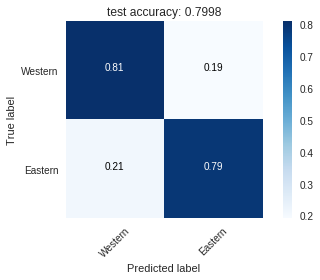

14.42 min used for category1-nonpooled-nonaugmentation:

----- train -----
accuracy: 0.9837 %
             precision    recall  f1-score   support

     london     0.9794    0.9896    0.9845       385
     moscow     0.9900    0.9802    0.9851       303
        nyc     0.9591    0.9925    0.9756       402
      paris     0.9774    0.9943    0.9858       348
  vancouver     0.9820    0.9647    0.9733       283
    beijing     0.9971    0.9769    0.9869       347
      kyoto     0.9842    0.9887    0.9865       442
      seoul     0.9928    0.9716    0.9821       282
  singapore     1.0000    0.9864    0.9931       220
      tokyo     0.9901    0.9836    0.9868       305

avg / total     0.9839    0.9837    0.9837      3317

----- test -----
accuracy: 0.4472 %
             precision    recall  f1-score   support

     london     0.3516    0.4639    0.4000        97
     moscow     0.5536    0.4079    0.4697        76
        nyc     0.4231    0.5446    0.4762       101
      paris     0.

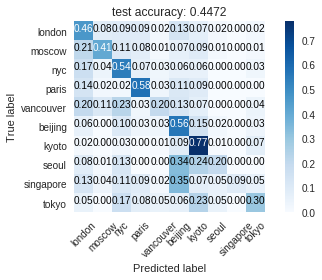

20.54 min used for category2-nonpooled-nonaugmentation:

34.96 min used for nonpooled-nonaugmentation:


In [0]:
base_name = 'nonpooled-nonaugmentation'

s1 = time.time()

model = SVC(kernel='rbf')
model.fit(X_npld_train, y1_train)

y1_train_pred = model.predict(X_npld_train)
y1_test_pred = model.predict(X_npld_test)

classes1 = [c for l, c in label2class1]
report(y1_train, y1_train_pred, 'train', classes1)
fig_name = 'category1-' + base_name
report(
    y1_test,
    y1_test_pred,
    'test',
    classes1,
    dir_path=dir_path,
    dir_name=dir_name,
    fig_name=fig_name)

e1 = time.time()
print('{:.2f} min used for {}:'.format((e1 - s1) / 60, fig_name), end='\n\n')

s2 = time.time()

model = SVC(kernel='rbf')
model.fit(X_npld_train, y2_train)

y2_train_pred = model.predict(X_npld_train)
y2_test_pred = model.predict(X_npld_test)

classes2 = [c for l, c in label2class2]
report(y2_train, y2_train_pred, 'train', classes2)
fig_name = 'category2-' + base_name
report(
    y2_test,
    y2_test_pred,
    'test',
    classes2,
    dir_path=dir_path,
    dir_name=dir_name,
    fig_name=fig_name)

e2 = time.time()
print('{:.2f} min used for {}:'.format((e2 - s2) / 60, fig_name), end='\n\n')

print('{:.2f} min used for {}:'.format((e2 - s1) / 60, base_name))

#### with augmentation

##### extract and set the extracted data


- test_size: 0.2 - augment: True - augment_mode: 0 augment_times: 1
extracting london data ...
extracting moscow data ...
extracting nyc data ...
extracting paris data ...
extracting vancouver data ...
extracting beijing data ...
extracting kyoto data ...
extracting seoul data ...
extracting singapore data ...
extracting tokyo data ...
1.67 min used for extraction:

----- train -----
accuracy: 0.9424 %
             precision    recall  f1-score   support

    Western     0.9458    0.9431    0.9444      1721
    Eastern     0.9388    0.9417    0.9403      1596

avg / total     0.9424    0.9424    0.9424      3317

----- test -----
accuracy: 0.7602 %
             precision    recall  f1-score   support

    Western     0.7019    0.9353    0.8020       433
    Eastern     0.8911    0.5711    0.6960       401

avg / total     0.7928    0.7602    0.7510       834

figure saved successfully to G/My Drive/dl4us/prj/figs/svm-on-extracted-features/category1-pooled-augment_mode0-augment_times1.p

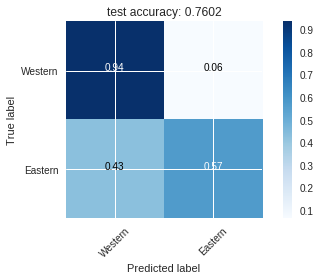

0.23 min used for category1-pooled-augment_mode0-augment_times1:

----- train -----
accuracy: 0.8749 %
             precision    recall  f1-score   support

     london     0.8708    0.8753    0.8731       385
     moscow     0.9303    0.8812    0.9051       303
        nyc     0.8551    0.9104    0.8819       402
      paris     0.8661    0.9109    0.8880       348
  vancouver     0.9115    0.8375    0.8729       283
    beijing     0.8832    0.8934    0.8883       347
      kyoto     0.8214    0.9367    0.8753       442
      seoul     0.8926    0.7660    0.8244       282
  singapore     0.9324    0.8773    0.9040       220
      tokyo     0.8596    0.8033    0.8305       305

avg / total     0.8769    0.8749    0.8745      3317

----- test -----
accuracy: 0.4556 %
             precision    recall  f1-score   support

     london     0.2895    0.5670    0.3833        97
     moscow     0.3761    0.5395    0.4432        76
        nyc     0.4348    0.5941    0.5021       101
      par

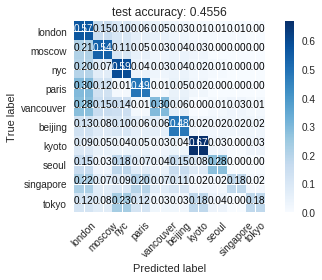

0.33 min used for category2pooled-augment_mode0-augment_times1:

0.56 min used for pooled-augment_mode0-augment_times1:

- test_size: 0.2 - augment: True - augment_mode: 0 augment_times: 5
extracting london data ...
extracting moscow data ...
extracting nyc data ...
extracting paris data ...
extracting vancouver data ...
extracting beijing data ...
extracting kyoto data ...
extracting seoul data ...
extracting singapore data ...
extracting tokyo data ...
5.37 min used for extraction:

----- train -----
accuracy: 0.9745 %
             precision    recall  f1-score   support

    Western     0.9766    0.9742    0.9754      8605
    Eastern     0.9723    0.9748    0.9735      7980

avg / total     0.9745    0.9745    0.9745     16585

----- test -----
accuracy: 0.7902 %
             precision    recall  f1-score   support

    Western     0.7329    0.9376    0.8227       433
    Eastern     0.9036    0.6309    0.7430       401

avg / total     0.8149    0.7902    0.7844       834

figure 

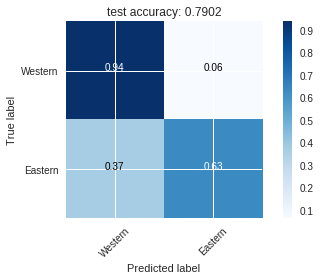

6.61 min used for category1-pooled-augment_mode0-augment_times5:

----- train -----
accuracy: 0.9603 %
             precision    recall  f1-score   support

     london     0.9513    0.9538    0.9525      1925
     moscow     0.9644    0.9650    0.9647      1515
        nyc     0.9425    0.9617    0.9520      2010
      paris     0.9547    0.9695    0.9621      1740
  vancouver     0.9698    0.9527    0.9611      1415
    beijing     0.9771    0.9608    0.9689      1735
      kyoto     0.9611    0.9738    0.9674      2210
      seoul     0.9667    0.9468    0.9566      1410
  singapore     0.9781    0.9727    0.9754      1100
      tokyo     0.9504    0.9416    0.9460      1525

avg / total     0.9604    0.9603    0.9603     16585

----- test -----
accuracy: 0.5036 %
             precision    recall  f1-score   support

     london     0.3621    0.6495    0.4649        97
     moscow     0.3976    0.4342    0.4151        76
        nyc     0.4167    0.5941    0.4898       101
      par

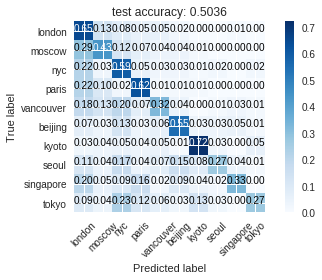

6.75 min used for category2pooled-augment_mode0-augment_times5:

13.36 min used for pooled-augment_mode0-augment_times5:

- test_size: 0.2 - augment: True - augment_mode: 1 augment_times: 1
extracting london data ...
extracting moscow data ...
extracting nyc data ...
extracting paris data ...
extracting vancouver data ...
extracting beijing data ...
extracting kyoto data ...
extracting seoul data ...
extracting singapore data ...
extracting tokyo data ...
1.74 min used for extraction:

----- train -----
accuracy: 0.9406 %
             precision    recall  f1-score   support

    Western     0.9451    0.9402    0.9426      1721
    Eastern     0.9358    0.9411    0.9385      1596

avg / total     0.9406    0.9406    0.9406      3317

----- test -----
accuracy: 0.7842 %
             precision    recall  f1-score   support

    Western     0.7908    0.7945    0.7926       433
    Eastern     0.7769    0.7731    0.7750       401

avg / total     0.7841    0.7842    0.7842       834

figure

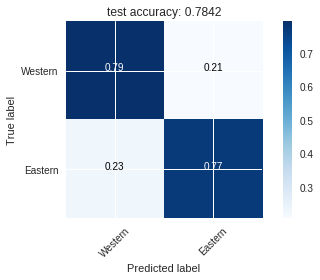

0.24 min used for category1-pooled-augment_mode1-augment_times1:

----- train -----
accuracy: 0.8794 %
             precision    recall  f1-score   support

     london     0.8835    0.9065    0.8949       385
     moscow     0.9130    0.9010    0.9070       303
        nyc     0.8224    0.8756    0.8482       402
      paris     0.8799    0.9052    0.8924       348
  vancouver     0.9046    0.8375    0.8697       283
    beijing     0.8743    0.9020    0.8879       347
      kyoto     0.8531    0.9457    0.8970       442
      seoul     0.8929    0.7979    0.8427       282
  singapore     0.9545    0.8591    0.9043       220
      tokyo     0.8881    0.8066    0.8454       305

avg / total     0.8811    0.8794    0.8791      3317

----- test -----
accuracy: 0.4173 %
             precision    recall  f1-score   support

     london     0.3333    0.3814    0.3558        97
     moscow     0.4571    0.4211    0.4384        76
        nyc     0.3729    0.4356    0.4018       101
      par

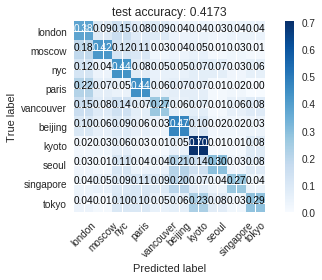

0.36 min used for category2pooled-augment_mode1-augment_times1:

0.60 min used for pooled-augment_mode1-augment_times1:

- test_size: 0.2 - augment: True - augment_mode: 1 augment_times: 5
extracting london data ...
extracting moscow data ...
extracting nyc data ...
extracting paris data ...
extracting vancouver data ...
extracting beijing data ...
extracting kyoto data ...
extracting seoul data ...
extracting singapore data ...
extracting tokyo data ...
5.25 min used for extraction:

----- train -----
accuracy: 0.9772 %
             precision    recall  f1-score   support

    Western     0.9775    0.9786    0.9780      8605
    Eastern     0.9769    0.9757    0.9763      7980

avg / total     0.9772    0.9772    0.9772     16585

----- test -----
accuracy: 0.7962 %
             precision    recall  f1-score   support

    Western     0.7942    0.8199    0.8068       433
    Eastern     0.7984    0.7706    0.7843       401

avg / total     0.7962    0.7962    0.7960       834

figure 

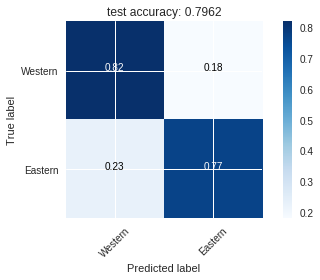

6.23 min used for category1-pooled-augment_mode1-augment_times5:

----- train -----
accuracy: 0.9606 %
             precision    recall  f1-score   support

     london     0.9443    0.9506    0.9475      1925
     moscow     0.9664    0.9670    0.9667      1515
        nyc     0.9430    0.9627    0.9527      2010
      paris     0.9649    0.9649    0.9649      1740
  vancouver     0.9695    0.9435    0.9563      1415
    beijing     0.9761    0.9660    0.9710      1735
      kyoto     0.9639    0.9792    0.9715      2210
      seoul     0.9703    0.9489    0.9595      1410
  singapore     0.9779    0.9655    0.9716      1100
      tokyo     0.9427    0.9489    0.9458      1525

avg / total     0.9607    0.9606    0.9606     16585

----- test -----
accuracy: 0.4988 %
             precision    recall  f1-score   support

     london     0.3738    0.4124    0.3922        97
     moscow     0.4872    0.5000    0.4935        76
        nyc     0.4649    0.5248    0.4930       101
      par

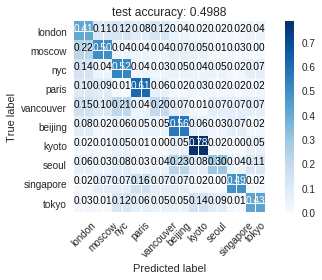

6.78 min used for category2pooled-augment_mode1-augment_times5:

13.01 min used for pooled-augment_mode1-augment_times5:



In [0]:
for augment_mode in (0, 1):
    for augment_times in (1, 5):

        base_name = 'pooled-augment_mode{}-augment_times{}'.format(
            augment_mode, augment_times)

        s0 = time.time()

        extracted_data = extract_gc(
            cities,
            gc_path=gc_path,
            weights='places',
            pooling='avg',
            test_size=0.2,
            random_state=42,
            augment=True,
            augment_mode=augment_mode,
            augment_times=augment_times,
            verbose=0,
        )

        (X_pld_train, X_pld_test), (y1_train, y1_test), (y2_train, y2_test), (
            label2class1, label2class2) = set_extracted_data(
                extracted_data, cities=cities, verbose=0)

        e0 = time.time()
        print(
            '{:.2f} min used for extraction:'.format((e0 - s0) / 60),
            end='\n\n')

        s1 = time.time()

        model = SVC(kernel='rbf', C=1.0)
        model.fit(X_pld_train, y1_train)
        y1_train_pred = model.predict(X_pld_train)
        y1_test_pred = model.predict(X_pld_test)

        classes1 = [c for label, c in label2class1]
        report(
            y1_train,
            y1_train_pred,
            'train',
            classes1,
        )
        plt.grid(None)
        fig_name = 'category1-' + base_name
        report(
            y1_test,
            y1_test_pred,
            'test',
            classes1,
            dir_path=dir_path,
            dir_name=dir_name,
            fig_name=fig_name)

        e1 = time.time()
        print(
            '{:.2f} min used for {}:'.format((e1 - s1) / 60, fig_name),
            end='\n\n')

        s2 = time.time()

        model = SVC(kernel='rbf', C=1.0)
        model.fit(X_pld_train, y2_train)
        y2_train_pred = model.predict(X_pld_train)
        y2_test_pred = model.predict(X_pld_test)

        classes2 = [c for label, c in label2class2]
        report(y2_train, y2_train_pred, 'train', classes2)
        plt.grid(None)
        fig_name = 'category2-' + base_name
        report(
            y2_test,
            y2_test_pred,
            'test',
            classes2,
            dir_path=dir_path,
            dir_name=dir_name,
            fig_name=fig_name)

        e2 = time.time()
        print(
            '{:.2f} min used for {}:'.format((e2 - s2) / 60, fig_name),
            end='\n\n')

        print('{:.2f} min used for {}:'.format((e2 - s1) / 60, base_name),
             end='\n\n')

### Transfer-Learning and Fine-Tune

#### import and set meta

In [0]:
from load_data import set_data_gc
from load_model import create_model, set_fine_tune
from set_generator import create_generator_gc, get_test_data
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from callbacks import SnapShot, Logger
from utils import report, save_model
from keras.models import load_model

# meta settings
batch_size = 128
augment_times = 5
print('batch_size:', batch_size)
print('augment_times:', augment_times)

Using TensorFlow backend.


batch_size: 128
augment_times: 5


#### set data

In [0]:
set_data_gc(
    gc_path=gc_path,
    cities=cities,
    test_size=0.1,
    validation_size=0.15,
    # random_state=42,
    random_state=41,
    verbose=1,
)

  0%|          | 0/10 [00:00<?, ?it/s]


processing london training data ...
processing london validation data ...
processing london test data ...


 10%|█         | 1/10 [00:09<01:26,  9.60s/it]


processing moscow training data ...
processing moscow validation data ...
processing moscow test data ...


 20%|██        | 2/10 [00:16<01:10,  8.77s/it]


processing nyc training data ...
processing nyc validation data ...
processing nyc test data ...


 30%|███       | 3/10 [00:25<01:02,  8.90s/it]


processing paris training data ...
processing paris validation data ...
processing paris test data ...


 40%|████      | 4/10 [00:33<00:51,  8.51s/it]


processing vancouver training data ...
processing vancouver validation data ...
processing vancouver test data ...


 50%|█████     | 5/10 [00:39<00:38,  7.75s/it]


processing beijing training data ...
processing beijing validation data ...
processing beijing test data ...


 60%|██████    | 6/10 [00:49<00:34,  8.51s/it]


processing kyoto training data ...
processing kyoto validation data ...
processing kyoto test data ...


 70%|███████   | 7/10 [01:03<00:30, 10.15s/it]


processing seoul training data ...
processing seoul validation data ...
processing seoul test data ...


 80%|████████  | 8/10 [01:09<00:17,  8.92s/it]


processing singapore training data ...
processing singapore validation data ...
processing singapore test data ...


 90%|█████████ | 9/10 [01:14<00:07,  7.64s/it]


processing tokyo training data ...
processing tokyo validation data ...
processing tokyo test data ...


100%|██████████| 10/10 [01:21<00:00,  7.42s/it]


all data saving has been done successfully


385


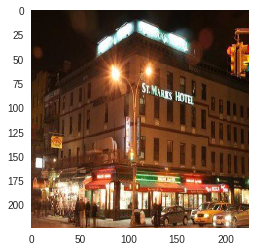

In [0]:
# 385 and the image of buildings in NYC should be shown below if random_state == 42
# 385 and the night corner in NYC should be shown below if rnadom_state == 41
plt.grid(None)
plt.imshow(Image.open(os.path.join(gc_path, 'data', 'train', 'nyc', '1.png')))
!ls -l -1 data/train/nyc/ | wc -l

#### transfer-learning

58916864/58909656 [==============================] - 5s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________

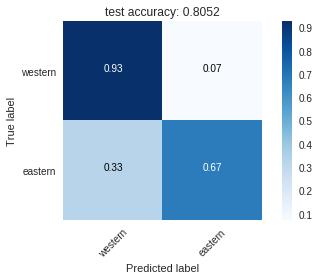

----- test -----
accuracy: 0.5154 %
             precision    recall  f1-score   support

     london     0.3816    0.5918    0.4640        49
     moscow     0.4630    0.6579    0.5435        38
        nyc     0.4405    0.7255    0.5481        51
      paris     0.6471    0.5000    0.5641        44
  vancouver     0.3704    0.2778    0.3175        36
    beijing     0.5556    0.5682    0.5618        44
      kyoto     0.7778    0.6250    0.6931        56
      seoul     0.4286    0.1667    0.2400        36
  singapore     0.7000    0.5000    0.5833        28
      tokyo     0.6364    0.3590    0.4590        39

avg / total     0.5425    0.5154    0.5083       421

figure saved successfully to G/My Drive/prj/figs/transfered/category2-512-avg-0.5vs1-random_state41.final.png


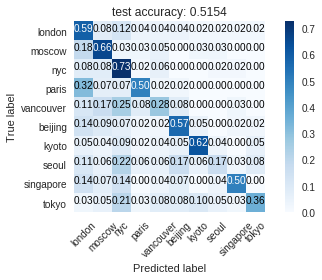

Found 421 images belonging to 10 classes.
----- test -----
accuracy: 0.7981 %
             precision    recall  f1-score   support

    western     0.7568    0.8991    0.8218       218
    eastern     0.8642    0.6897    0.7671       203

avg / total     0.8086    0.7981    0.7954       421

figure saved successfully to G/My Drive/prj/figs/transfered/category1-512-avg-0.5vs1-random_state41.best.png


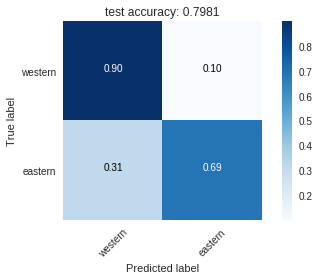

----- test -----
accuracy: 0.5107 %
             precision    recall  f1-score   support

     london     0.3944    0.5714    0.4667        49
     moscow     0.4894    0.6053    0.5412        38
        nyc     0.4222    0.7451    0.5390        51
      paris     0.6452    0.4545    0.5333        44
  vancouver     0.3929    0.3056    0.3438        36
    beijing     0.5417    0.5909    0.5652        44
      kyoto     0.7347    0.6429    0.6857        56
      seoul     0.4706    0.2222    0.3019        36
  singapore     0.6296    0.6071    0.6182        28
      tokyo     0.6154    0.2051    0.3077        39

avg / total     0.5357    0.5107    0.4993       421

figure saved successfully to G/My Drive/prj/figs/transfered/category2-512-avg-0.5vs1-random_state41.best.png


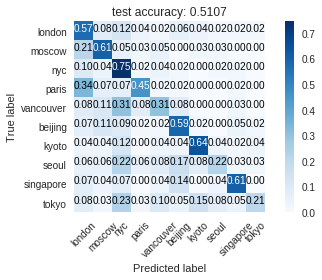

In [0]:
### hyperparameters ###
dir_name = 'transfered'
units, pooling, loss_weights = 512, 'avg', (0.5, 1)
base_name = '{}-{}-{}vs{}-random_state41'.format(units, pooling, *loss_weights)

model = create_model(
    n_class2=len(cities),
    n_class1=2,
    weights='places',
    pooling=pooling,
    units=units,
    drop_rate=0.5,
    optimizer='nadam',
    loss_weights=loss_weights,
)
model.summary()

train_gen, default_steps, (label2class1, label2class2) = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='train',
    batch_size=batch_size,
    random_state=42,
)
steps_per_epoch = default_steps * augment_times
valid_gen, validation_steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='validate',
    batch_size=batch_size,
    random_state=42,
)

epochs = 50
rlr = ReduceLROnPlateau(
    monitor='val_output2_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=2,
)
ss = SnapShot(
    dir_path, dir_name, base_name, monitor='val_output2_acc', mode='max')
cl = Logger(dir_path, dir_name, base_name)

hist = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=[
        rlr,
        ss,
        cl,
    ],
    verbose=2,
)

######## test below #######

X_test, (y1_test, y2_test), (label2class1, label2class2) = get_test_data(
    gc_path=gc_path,
    cities=cities,
    batch_size=batch_size,
    random_state=42,
)

classes1 = [c for l, c in label2class1]
classes2 = [c for l, c in label2class2]

### test with the final model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.final'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.final'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

### test with the best model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

model = load_model(
    os.path.join(dir_path, 'models', dir_name, base_name + '.best.h5'))

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.best'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.best'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

#### fine-tune

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

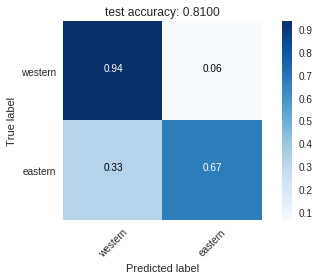

----- test -----
accuracy: 0.5368 %
             precision    recall  f1-score   support

     london     0.3671    0.5918    0.4531        49
     moscow     0.4717    0.6579    0.5495        38
        nyc     0.5205    0.7451    0.6129        51
      paris     0.6562    0.4773    0.5526        44
  vancouver     0.4194    0.3611    0.3881        36
    beijing     0.6098    0.5682    0.5882        44
      kyoto     0.7308    0.6786    0.7037        56
      seoul     0.6667    0.3333    0.4444        36
  singapore     0.6316    0.4286    0.5106        28
      tokyo     0.5652    0.3333    0.4194        39

avg / total     0.5651    0.5368    0.5334       421

figure saved successfully to G/My Drive/prj/figs/fine-tuned/category2-512-avg-0.5vs1-random_state41-15.final.png


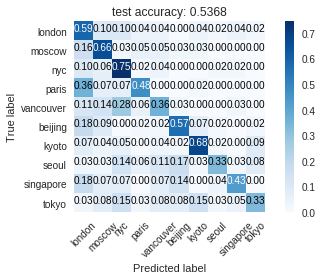

Found 421 images belonging to 10 classes.
----- test -----
accuracy: 0.8052 %
             precision    recall  f1-score   support

    western     0.7519    0.9312    0.8320       218
    eastern     0.9007    0.6700    0.7684       203

avg / total     0.8236    0.8052    0.8013       421

figure saved successfully to G/My Drive/prj/figs/fine-tuned/category1-512-avg-0.5vs1-random_state41-15.best.png


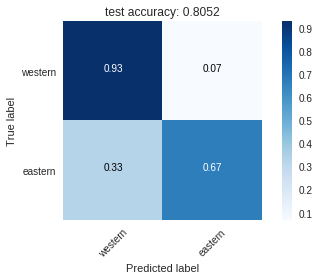

----- test -----
accuracy: 0.5392 %
             precision    recall  f1-score   support

     london     0.3766    0.5918    0.4603        49
     moscow     0.4717    0.6579    0.5495        38
        nyc     0.5065    0.7647    0.6094        51
      paris     0.6667    0.5000    0.5714        44
  vancouver     0.4062    0.3611    0.3824        36
    beijing     0.6000    0.5455    0.5714        44
      kyoto     0.7308    0.6786    0.7037        56
      seoul     0.6875    0.3056    0.4231        36
  singapore     0.6842    0.4643    0.5532        28
      tokyo     0.5909    0.3333    0.4262        39

avg / total     0.5711    0.5392    0.5352       421

figure saved successfully to G/My Drive/prj/figs/fine-tuned/category2-512-avg-0.5vs1-random_state41-15.best.png


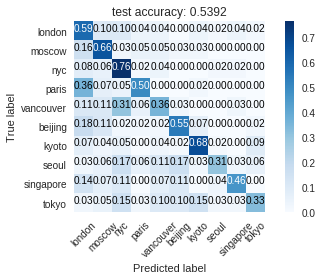

In [0]:
### hyperparameters ###
dir_name = 'fine-tuned'
trans_name = '512-avg-0.5vs1-random_state41'
model_file_path = os.path.join(dir_path, 'models', 'transfered', trans_name + '.best.h5')
freeze = 15

model = set_fine_tune(
    model_file_path,
    freeze=freeze,
    # optimizer=SGD(lr=1e-4, momentum=0.9, nesterov=True),
    loss_weights=None, # gonna use the same weights
)
model.summary()

base_name = '{}-{}'.format(trans_name, freeze)

train_gen, default_steps, (label2class1, label2class2) = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='train',
    batch_size=batch_size,
    random_state=42,
)
steps_per_epoch = default_steps * augment_times
valid_gen, validation_steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='validate',
    batch_size=batch_size,
    random_state=42,
)

epochs = 100
rlr = ReduceLROnPlateau(
    monitor='val_output2_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=2)
ss = SnapShot(
    dir_path, dir_name, base_name, monitor='val_output2_acc', mode='max')
cl = Logger(dir_path, dir_name, base_name)

hist = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=[
        rlr,
        ss,
        cl,
    ],
    verbose=2,
)

######## test below #######

X_test, (y1_test, y2_test), (label2class1, label2class2) = get_test_data(
    gc_path=gc_path,
    cities=cities,
    batch_size=batch_size,
    random_state=42,
)

classes1 = [c for l, c in label2class1]
classes2 = [c for l, c in label2class2]

### test with the final model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.final'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.final'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

### test with the best model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

model = load_model(
    os.path.join(dir_path, 'models', dir_name, base_name + '.best.h5'))

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.best'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.best'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)